In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\johnn\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
df = pd.read_csv('Resumetest.csv');
df.head(10)

,Index,Resume_text
0,1,Technical IT Agile Project Manager / Scrum Mas...
1,2,Certified Project Management Professional (PMP...
2,3,Mr. Agee serves as a Partner and Board Member ...
3,4,Ms. Morin-Kensicki brings over 20 years of pro...
4,5,Information Technology Professional with six y...
5,6,Mr. Thomas Pagurek\n\nTechnical Services Manag...
6,7,"I’m looking to forward my career, which focuse..."
7,8,Attain LLC\nChief Engineer & Infrastructure Op...
8,9,"Chesapeake Bay Program | Annapolis, MD\t(05/20..."
9,10,"Mary Baldwin University Library Assistant, Gra..."


## Text preprocessing  

In [4]:
# Convert to list
data = df.Resume_text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: Dep

['Technical IT Agile Project Manager / Scrum Master who works tirelessly with '
 'relevant stakeholders to manage benefits throughout the project life cycle '
 'for benefit realization at project completion; grasps organizational culture '
 'and project environment and initiatives as well as business strategies and '
 'structure quickly; a strong influencer with emotional intelligence, strong '
 'business acumen, situational awareness; and tuned to lead diverse project '
 'teams driving performance through coaching and mentoring. As a previous '
 'principal with Solutionersnet, I have always worked diligently on process '
 'improvement and thrives to provide solid leadership to all teams. Expertise '
 'in full project management life cycle with high degree of expertise in '
 'Agile/Scrum Supported the Department of Commerce – Census Bureau as a senior '
 'project manager for multiple projects to help ensure the 2020 Decennial '
 'Census meets the high congressional demands of reduced c

## Tokenize and data clean-up

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['technical', 'it', 'agile', 'project', 'manager', 'scrum', 'master', 'who', 'works', 'tirelessly', 'with', 'relevant', 'stakeholders', 'to', 'manage', 'benefits', 'throughout', 'the', 'project', 'life', 'cycle', 'for', 'benefit', 'realization', 'at', 'project', 'completion', 'grasps', 'organizational', 'culture', 'and', 'project', 'environment', 'and', 'initiatives', 'as', 'well', 'as', 'business', 'strategies', 'and', 'structure', 'quickly', 'strong', 'influencer', 'with', 'emotional', 'intelligence', 'strong', 'business', 'acumen', 'situational', 'awareness', 'and', 'tuned', 'to', 'lead', 'diverse', 'project', 'teams', 'driving', 'performance', 'through', 'coaching', 'and', 'mentoring', 'as', 'previous', 'principal', 'with', 'solutionersnet', 'have', 'always', 'worked', 'diligently', 'on', 'process', 'improvement', 'and', 'thrives', 'to', 'provide', 'solid', 'leadership', 'to', 'all', 'teams', 'expertise', 'in', 'full', 'project', 'management', 'life', 'cycle', 'with', 'high', 'deg

## Lemmatization 

In [6]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['technical agile project manager scrum master who work tirelessly relevant stakeholder manage benefit project life cycle benefit realization project completion grasp organizational culture project environment initiative as well business strategy structure quickly strong influencer emotional intelligence strong business acuman situational awareness tune lead diverse project team drive performance coaching mentor previous principal solutionersnet have always work diligently process improvement thrif provide solid leadership team expertise full project management life cycle high degree expertise agile scrum support department commerce census bureau senior project manager multiple project help ensure decennial census meet high congressional demand reduced cost increase efficiency appropriate use enterprise technology current project manager project have be task manage enhancement development mission critical system support census have successfully implement process ensure project stay sch

Output the cleaned list to csv file for other methond usage.

In [9]:
import csv

res = data_lemmatized
csvfile = "resume_cleaned.csv"

#Assuming res is a flat list
with open(csvfile, "w",encoding = 'UTF-8') as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in res:
        writer.writerow([val]) 

## Create the document word matrix

In [7]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

## Sparsicity

Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix.

In [8]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  23.94695590614887 %


## Building LDA model with SKlearn

In [9]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


## Check model performance with perplexity and log-likelihood 

In [10]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -308160.1758226252
Perplexity:  568.2556677249064
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 20,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


## Grid search the best LDA model

In [11]:
# Define Search Param
search_params = {'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\johnn\Anaconda3\lib\site-packages\skl

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\johnn\Anaconda3\lib\site-packages\skl

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\johnn\Anaconda3\lib\site-packages\skl

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## Check the parameters for the best model 

In [12]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_topics': 10}
Best Log Likelihood Score:  -107299.24419811962
Model Perplexity:  437.8224149213946


In [16]:
print(best_lda_model)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.5, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1, n_topics=10,
             perp_tol=0.1, random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


## Compare LDA model performance scores

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


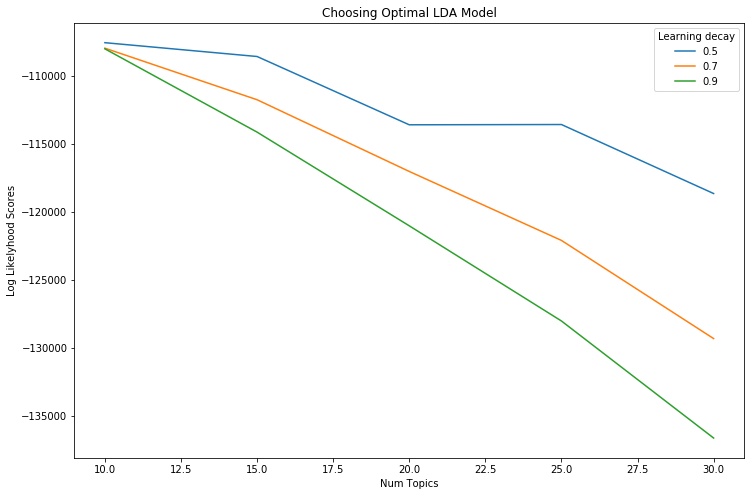

In [46]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## The dominant topic in each document(resume) 

In [54]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0,0,0,0,0,1,0,0,0,0,5
Doc1,0,0,0,0,0.74,0.26,0,0,0,0,4
Doc2,0.24,0,0,0,0.02,0.31,0,0,0.42,0,8
Doc3,0.01,0,0,0,0,0.56,0,0,0.42,0,5
Doc4,0,0,0,0,0,0,0,0,1,0,8
Doc5,0,0,0,0.04,0,0.35,0,0,0.61,0,8
Doc6,0.21,0,0,0,0.39,0.11,0,0,0.28,0,4
Doc7,0,0,0,0.51,0,0.09,0,0,0.4,0,3
Doc8,0,0,0,0,0,0,0,0,0,1,9
Doc9,0.7,0.16,0,0,0.13,0,0,0,0,0,0


## Review topics distribution across documents

In [55]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,8,25
1,5,22
2,4,20
3,3,20
4,0,6
5,1,5
6,7,3
7,9,1
8,2,1


## Visulization with LDA model

In [56]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics          x          y
topic                                                  
5      26.233764        1       1  33.834251  -9.165401
4      21.666737        1       2 -75.572372  12.163972
8      20.224330        1       3  -9.181776  30.075104
3      17.733277        1       4  84.608963  23.498335
0       7.998653        1       5 -43.581890  78.326431
1       4.309505        1       6  35.559498  72.276199
7       1.064370        1       7 -21.757980 -26.817198
9       0.459533        1       8  72.568474 -55.085476
2       0.288707        1       9   7.852280 -81.725487
6       0.021123        1      10 -68.713066 -62.735054, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
431   Default   974.000000   management   974.000000  30.0000  30.0000
191   Default   285.000000        datum   285.000000  29.0000  29.0000
159   Default   374.000000     contract   374.000000  28.0000  28.0000
561   Default   458.000000      program   458.000000  27.0000  27.0000
565   Default  1067.000000      project  1067.000000  26.0000  26.0000
496   Default   200.000000    operation   200.000000  25.0000  25.0000
568   Default   210.000000     proposal   210.000000  24.0000  24.0000
365   Default   278.000000  information   278.000000  23.0000  23.0000
763   Default   336.000000         work   336.000000  22.0000  22.0000
37    Default   265.000000     analysis   265.000000  21.0000  21.0000
185   Default   297.000000     customer   297.000000  20.0000  20.0000
430   Default   461.000000       manage   461.000000  19.0000  19.0000
572   Default   466.000000      provide   466.000000  18.0000  18.0000
702   Default   539.000000         team   539.000000  17.0000  17.0000
280   Default   293.000000   experience   293.000000  16.0000  16.0000
489   Default   132.000000       office   132.000000  15.0000  15.0000
551   Default   342.000000      process   342.000000  14.0000  14.0000
708   Default   172.000000         test   172.000000  13.0000  13.0000
698   Default   761.000000      support   761.000000  12.0000  12.0000
215   Default   473.000000  development   473.000000  11.0000  11.0000
517   Default   166.000000      perform   166.000000  10.0000  10.0000
706   Default   324.000000   technology   324.000000   9.0000   9.0000
213   Default   388.000000      develop   388.000000   8.0000   8.0000
649   Default   523.000000      service   523.000000   7.0000   7.0000
15    Default   100.000000     activity   100.000000   6.0000   6.0000
642   Default   310.000000     security   310.000000   5.0000   5.0000
476   Default   308.000000      network   308.000000   4.0000   4.0000
704   Default   253.000000    technical   253.000000   3.0000   3.0000
738   Default   294.000000          use   294.000000   2.0000   2.0000
720   Default   272.000000     training   272.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
763   Topic10     0.034641         work   336.599547  -0.7190  -5.6912
159   Topic10     0.035426     contract   374.220551  -0.8026  -5.6688
431   Topic10     0.045487   management   974.225994  -1.5094  -5.4189
70    Topic10     0.018612       august    51.982574   0.5277  -6.3124
612   Topic10     0.025557     research   163.758987  -0.3027  -5.9954
37    Topic10     0.029093     analysis   265.836236  -0.6576  -5.8658
93    Topic10     0.032635     business   502.899399  -1.1802  -5.7509
388   Topic10     0.018204      involve    61.576512   0.3361  -6.3347
41    Topic10     0.018850      analyze    74.467811   0.1809  -6.2998
606   Topic10     0.025095       report   277.562232  -0.8486  -6.0136
738   Topic10     0.025357          use   294.908736  -0.8988  -6.0032
702   Topic10     0.028027         team   539.888616  -1.4034  -5.9031
715   Topic10     0.021526         tool   153.653475  -0.4106  -6.1670
572   Topic10     0

## Each topic's key words

In [58]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head(10)

,ability,academic,acceptance,access,accomplishment,account,accounting,accuracy,accurate,achieve,...,wide,win,window,wireless,word,work,world,write,writing,year
Topic0,4.079897,1.111757,0.171221,1.738864,0.832487,33.500883,11.352388,0.234724,2.808467,5.270346,...,0.598671,1.915911,0.485675,0.223887,0.283590,22.572132,0.352988,3.481232,0.166639,12.254072
Topic1,0.165571,1.086437,0.161946,3.724892,3.743854,9.226098,1.461533,1.902872,4.958713,0.292815,...,1.912441,9.067016,0.188959,0.150113,4.003295,17.697545,0.211331,10.297557,4.700451,8.614699
Topic2,0.174294,0.159426,0.149706,2.827832,0.208593,0.274117,0.215996,0.158776,0.154405,1.157300,...,0.202301,0.156866,0.194015,0.149637,0.146199,0.269086,0.146879,0.168344,0.151909,0.364261
Topic3,9.391401,1.598557,1.102641,16.624931,9.327530,24.596472,1.826678,1.473071,3.144836,5.595547,...,18.550652,1.499154,90.063107,13.859056,6.177856,68.841370,0.526617,7.943476,0.616402,29.485797
Topic4,4.590529,2.861716,5.273691,19.248844,1.353525,15.928952,6.056017,3.390675,2.313521,3.402059,...,6.807627,5.329472,13.527916,4.656214,6.754396,127.899823,4.804447,1.867595,0.333077,24.335706
Topic5,9.887726,0.214255,5.316001,4.295194,35.140140,12.946430,1.893582,2.221877,0.212023,27.603953,...,15.530502,0.715409,1.366398,3.389319,0.201257,64.749623,0.257191,11.190748,6.392303,58.917321
Topic6,0.154494,0.165315,0.170214,0.175648,0.176740,0.190438,0.155942,0.152522,0.142787,0.151526,...,0.148991,0.150755,0.164763,0.141135,0.164298,0.442870,0.151536,0.161570,0.150425,0.202681
Topic7,4.930808,0.150871,0.154692,0.231578,0.174650,4.001815,1.111472,1.094843,1.104381,0.173094,...,0.235147,0.163803,0.381636,0.203404,1.323531,5.159658,0.148911,1.127318,0.176479,1.217488
Topic8,3.004244,8.184087,0.197028,29.363261,7.308234,15.255918,1.895571,0.175980,1.620305,8.918697,...,23.778569,14.549234,16.469075,10.813273,3.118709,20.190013,7.038900,3.962742,2.861498,31.019888
Topic9,0.193093,1.099176,0.145506,1.044537,0.148807,0.395697,0.191915,0.159756,0.193381,0.162990,...,0.163492,0.166569,1.071380,0.160759,0.151302,3.043762,0.146682,0.173612,1.115336,0.201553


## Top 15 keywords each topic 

In [59]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,contract,support,management,include,business,manager,project,proposal,grant,award,financial,agreement,provide,federal,administration
Topic 1,proposal,project,create,support,graphic,manage,production,team,process,technical,report,design,ensure,work,include
Topic 2,defense,operation,office,activity,intelligence,dod,information,chief,improve,program,leadership,staff,special,policy,access
Topic 3,support,management,server,application,service,manager,user,project,include,team,implementation,network,provide,use,customer
Topic 4,project,management,business,support,application,database,oracle,work,use,team,test,provide,develop,datum,report
Topic 5,project,management,program,development,team,manager,manage,lead,business,develop,process,service,provide,support,product
Topic 6,project,management,test,datum,contract,work,business,analysis,team,testing,provide,research,program,use,report
Topic 7,customer,production,team,service,june,graphic,corporate,responsible,experience,august,bank,provide,work,end,high
Topic 8,security,network,management,service,information,technology,support,project,analysis,manage,program,training,provide,business,computer
Topic 9,datum,management,perform,lab,assistant,help,assist,analysis,medical,care,manage,research,provide,work,experience


## Predicting the related topic words for a new text 

In [70]:
# Define function to predict topic for a given text document.
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["project and management"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['project', 'management', 'program', 'development', 'team', 'manager', 'manage', 'lead', 'business', 'develop', 'process', 'service', 'provide', 'support', 'product']


## Cluster documents that share similar topics and plot 

In [71]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=10, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.09  0.02  0.    0.36  0.37  0.55  0.    0.01  0.65  0.  ]
 [-0.04 -0.    0.    0.85  0.03 -0.53  0.    0.01 -0.03  0.  ]]
Perc of Variance Explained: 
 [0.06 0.27]


Text(0.5,1,'Segregation of Topic Clusters')

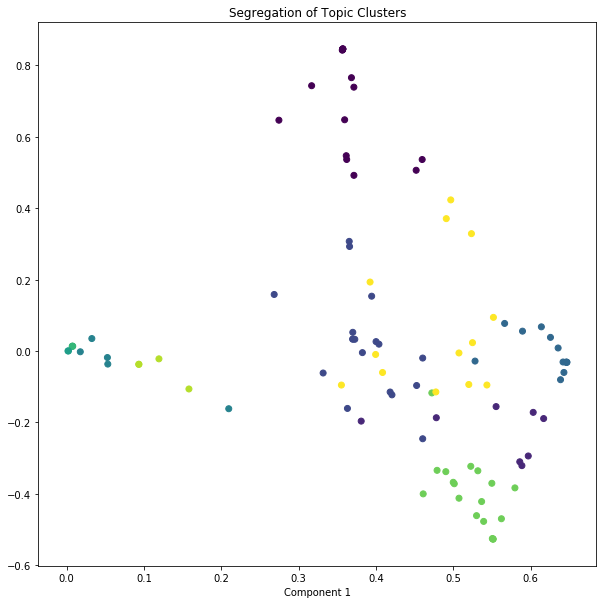

In [73]:
# Plot
plt.figure(figsize=(10, 10))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

## Finding similar documents(resumes) for any given piece of text input

In [66]:
from sklearn.metrics.pairwise import euclidean_distances

import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [68]:
# Get similar documents
mytext = ["Some text about project and management"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:500])

Topic KeyWords:  ['project', 'management', 'program', 'development', 'team', 'manager', 'manage', 'lead', 'business', 'develop', 'process', 'service', 'provide', 'support', 'product']
Topic Prob Scores of text:  [[0.  0.  0.  0.  0.  0.7 0.  0.  0.  0. ]]
Most Similar Doc's Probs:   [[0.  0.  0.  0.1 0.  0.8 0.  0.  0.  0. ]]

 Mr. Aslam Nawabzada Result oriented technology leader with 20 years of experience in business and IT including strategic planning, software product development, system implementation and support, managing complex IT solutions and business & technology transformation. Strategically and cost effectively utilized technology in alignment with corporate goals. Computer Engineering and MBA Degree. IT Leadership  Optimal technology selection and implementation  Building alliances with senior business
